In [1]:
import configparser
from helpers.helper_functions import *
from helpers.helper_classes import *
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from matplotlib import pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee']) 
plt.rcParams['figure.dpi'] = 100

# Read config.ini file
config = configparser.ConfigParser()
config.read('src/config.ini')

# Read dataframes from parquet
print('Loading data...')
df = pd.read_parquet(config['PATH']['DATA_DIR'] + '/training_set.parquet', engine = 'fastparquet')
df_test = pd.read_parquet(config['PATH']['DATA_DIR'] + '/test_set.parquet', engine = 'fastparquet')

c:\Users\caspa\Desktop\data-mining-techniques-vu\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data...


In [2]:
df.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate'

In [3]:
# Create a descriptive statistics table 
# Columns: count, # unique, min, max, mean
# for all columns

desc_df = df.describe().transpose()
desc_df['unique'] = df.nunique()
desc_df['null %'] = df.isnull().sum() / len(df) * 100

# drop 25, 50, 75 percentile
desc_df.drop(['25%', '50%', '75%', 'count'], axis = 1, inplace = True)

# drop std
desc_df.drop(['std'], axis = 1, inplace = True)

# mean to float for all rows
desc_df.loc['srch_id', 'mean'] = desc_df.loc['srch_id', 'mean'].astype('float64')

# drop all comp... rows
desc_df = desc_df[~desc_df.index.str.contains('comp')]
# drop position, promotion flag, random_bool, click_bool, gross_bookings_usd
desc_df.drop(['position', 'promotion_flag', 'booking_bool', 'random_bool', 'click_bool', 'gross_bookings_usd', 'orig_destination_distance'], axis = 0, inplace = True)

# for datetime truncate to date only
# desc_df.loc['date_time', 'min'] = desc_df.loc['date_time', 'min'].date()
# desc_df.loc['date_time', 'max'] = desc_df.loc['date_time', 'max'].date()
# desc_df.loc['date_time', 'mean'] = desc_df.loc['date_time', 'mean'].date()

# order: unique, min, max, mean, null %
desc_df = desc_df[['unique', 'min', 'max', 'mean', 'null %']]


In [4]:
# round to 2 decimals
desc_df = desc_df.round(2)
print(desc_df.to_latex(escape=True, float_format="%.2f"))


\begin{tabular}{lrrrrr}
\toprule
 & unique & min & max & mean & null \% \\
\midrule
srch\_id & 199795 & 1.00 & 332785.00 & 166366.56 & 0.00 \\
site\_id & 34 & 1.00 & 34.00 & 9.95 & 0.00 \\
visitor\_location\_country\_id & 210 & 1.00 & 231.00 & 175.34 & 0.00 \\
visitor\_hist\_starrating & 312 & 1.41 & 5.00 & 3.37 & 94.92 \\
visitor\_hist\_adr\_usd & 7799 & 0.00 & 1958.70 & 176.02 & 94.90 \\
prop\_country\_id & 172 & 1.00 & 230.00 & 173.97 & 0.00 \\
prop\_id & 129113 & 1.00 & 140821.00 & 70079.18 & 0.00 \\
prop\_starrating & 6 & 0.00 & 5.00 & 3.18 & 0.00 \\
prop\_review\_score & 10 & 0.00 & 5.00 & 3.78 & 0.15 \\
prop\_brand\_bool & 2 & 0.00 & 1.00 & 0.63 & 0.00 \\
prop\_location\_score1 & 337 & 0.00 & 6.98 & 2.87 & 0.00 \\
prop\_location\_score2 & 9342 & 0.00 & 1.00 & 0.13 & 21.99 \\
prop\_log\_historical\_price & 392 & 0.00 & 6.21 & 4.32 & 0.00 \\
price\_usd & 76465 & 0.00 & 19726328.00 & 254.21 & 0.00 \\
srch\_destination\_id & 18127 & 2.00 & 28416.00 & 14042.63 & 0.00 \\
srch\_length\

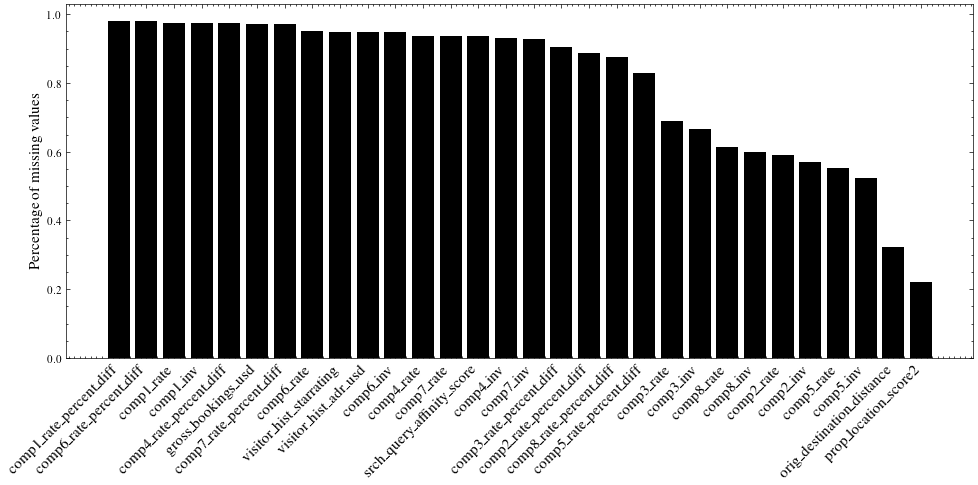

In [5]:
import numpy as np

no_bars = 30

missing_values = df.isnull().sum().sort_values(ascending=False) / len(df)
missing_values = missing_values[missing_values > 0]

plt.figure(figsize=(10, 5))
plt.bar(missing_values.index[:no_bars], missing_values[:no_bars])
plt.xticks(np.arange(no_bars), missing_values.index[:no_bars], rotation=45, ha='right', fontsize=11)
plt.ylabel('Percentage of missing values', fontsize=11)
plt.tight_layout()
plt.savefig(config['PATH']['FIGURE_DIR'] + '/missing_values.pdf')
plt.show()


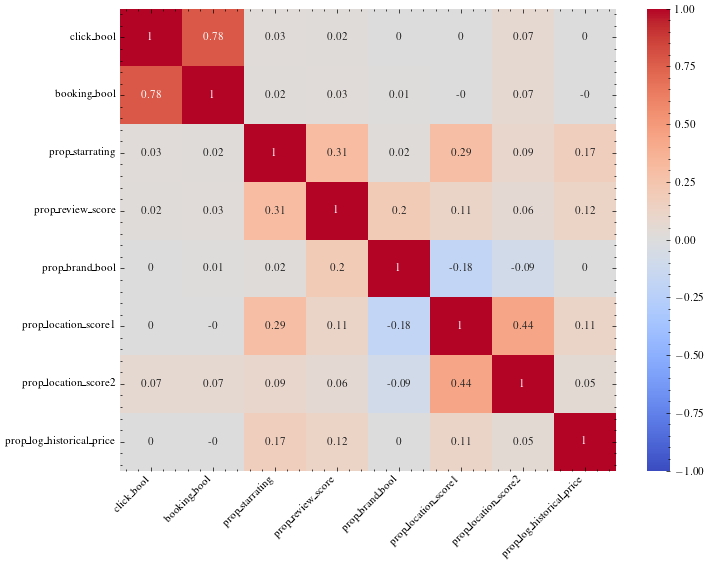

In [11]:
df.columns

prop_cols = [col for col in df.columns if 'prop_' in col]
prop_cols = prop_cols[2:]
prop_cols.insert(0, 'booking_bool')
prop_cols.insert(0, 'click_bool')

plot_correlation_heatmap(df, prop_cols, rotate_labels=True, savename=config['PATH']['FIGURE_DIR'] + '/corr_prop_hm.pdf')

In [8]:
src_cols

['srch_id',
 'srch_destination_id',
 'srch_length_of_stay',
 'srch_booking_window',
 'srch_adults_count',
 'srch_children_count',
 'srch_room_count',
 'srch_saturday_night_bool',
 'srch_query_affinity_score']